# ResNet-50 model on the Oxford-IIIT Pet Dataset

The provided code is an implementation of training and validation loops for fine-tuning a ResNet-50 model on the Oxford-IIIT Pet Dataset. It modifies the fully connected layer of the ResNet-50 model to match the number of classes (with an additional class), defines loss, optimizer, and loops for training and validation.

In [34]:
import os
from PIL import Image

# Set path to dataset directory
dataset_dir = '/Users/manvendrasharma/Desktop/Oxford-IIIT_Pets_Dataset'


# Define function to read classes
def read_classes(file_path):
    classes = {}
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if line.startswith('#'):
                continue  # Skip comment lines
            line = line.strip().split()
            image_name = line[0]
            class_id = int(line[1])
            species = int(line[2])
            breed = int(line[3])
            classes[image_name] = {'class_id': class_id, 'species': species, 'breed': breed}
    return classes

# Read classes file
classes_file = os.path.join(dataset_dir, 'annotations', 'list.txt')
classes = read_classes(classes_file)

# Define function to read train/test split
def read_train_test_split(file_path):
    with open(file_path, 'r') as f:
        file_names = [line.strip().split(' ')[0].rstrip() for line in f.readlines()]
    return file_names


# Read train/test split files
trainval_file = os.path.join(dataset_dir, 'annotations', 'trainval.txt')
test_file = os.path.join(dataset_dir, 'annotations', 'test.txt')
trainval_files = read_train_test_split(trainval_file)
test_files = read_train_test_split(test_file)

# Print classes
for file_name, class_info in classes.items():
    print('File Name:', file_name)
    print('Class ID:', class_info['class_id'])
    print('Species:', class_info['species'])
    print('Breed:', class_info['breed'])
    print()

# Print train/test split
print('Train/Val Files:', len(trainval_files))
print('Test Files:', len(test_files))


# Set the desired dimensions for resizing
target_width = 224
target_height = 224

# Resize images in the dataset
for file_name in os.listdir(dataset_dir):
    if file_name.endswith('.jpg'):
        image_path = os.path.join(dataset_dir, file_name)
        image = Image.open(image_path)
        resized_image = image.resize((target_width, target_height))
        resized_image.save(image_path)


File Name: Abyssinian_100
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_101
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_102
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_103
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_104
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_105
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_106
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_107
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_108
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_109
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_10
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_110
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_111
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_112
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_113
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_114
Class ID: 1
Species: 1
Breed: 1

File Name: Abyssinian_115
Class ID: 1
Species: 1
Breed: 1

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from PIL import Image

class PetDataset(Dataset):
    def __init__(self, file_names, classes, dataset_dir, transformations=None):
        self.file_names = file_names
        self.classes = classes
        self.dataset_dir = dataset_dir
        self.transformations = transformations

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        file_name = self.file_names[index]
        image_path = os.path.join(self.dataset_dir, 'images', file_name + '.jpg')  # Include the file extension .jpg
        image = Image.open(image_path)
        # Convert the image to RGB format
        image = image.convert("RGB")

        # Resize the image
        resized_image = image.resize((224, 224))
        class_info = self.classes[file_name]
        class_id = class_info['class_id']
        species = class_info['species']
        breed = class_info['breed']

        if self.transformations is not None:
            image = self.transformations(image)

        return image, class_id, species, breed


# Set hyperparameters
num_classes = 37
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# Define data transformations
transformations = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainval_dataset = PetDataset(trainval_files, classes, dataset_dir, transformations['train'])
test_dataset = PetDataset(test_files, classes, dataset_dir, transformations['val'])

trainval_dataloader = DataLoader(trainval_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [40]:
from torchvision.models import resnet50

# Load pretrained Resnet50 model
model = resnet50(pretrained=True)

# Modify the last layer of the model to match the number of animal breed classes (37 in this case)
num_features = model.fc.in_features
#model.fc = nn.Linear(num_features, num_classes)
model.fc = nn.Linear(num_features, num_classes + 1)  # Add 1 to the number of classes

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, class_ids, _, _ in dataloader:
        images = images.to(device)
        class_ids = class_ids.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, class_ids)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

# Validation loop
def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for images, class_ids, _, _ in dataloader:
            images = images.to(device)
            class_ids = class_ids.to(device)

            outputs = model(images)
            loss = criterion(outputs, class_ids)
            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += torch.sum(predicted == class_ids).item()

    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct_predictions / len(dataloader.dataset)
    return epoch_loss, accuracy


In [41]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_loss = train(model, trainval_dataloader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_dataloader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")


Epoch 1/10
Train Loss: 2.4641 | Val Loss: 0.8022 | Val Accuracy: 0.8733
Epoch 2/10
Train Loss: 0.9608 | Val Loss: 0.4205 | Val Accuracy: 0.9000
Epoch 3/10
Train Loss: 0.6468 | Val Loss: 0.3194 | Val Accuracy: 0.9188
Epoch 4/10
Train Loss: 0.5516 | Val Loss: 0.2954 | Val Accuracy: 0.9174
Epoch 5/10
Train Loss: 0.4817 | Val Loss: 0.2541 | Val Accuracy: 0.9278
Epoch 6/10
Train Loss: 0.4112 | Val Loss: 0.2486 | Val Accuracy: 0.9278
Epoch 7/10
Train Loss: 0.3918 | Val Loss: 0.2551 | Val Accuracy: 0.9212
Epoch 8/10
Train Loss: 0.3878 | Val Loss: 0.2381 | Val Accuracy: 0.9256
Epoch 9/10
Train Loss: 0.3505 | Val Loss: 0.2455 | Val Accuracy: 0.9253
Epoch 10/10
Train Loss: 0.3233 | Val Loss: 0.2304 | Val Accuracy: 0.9294


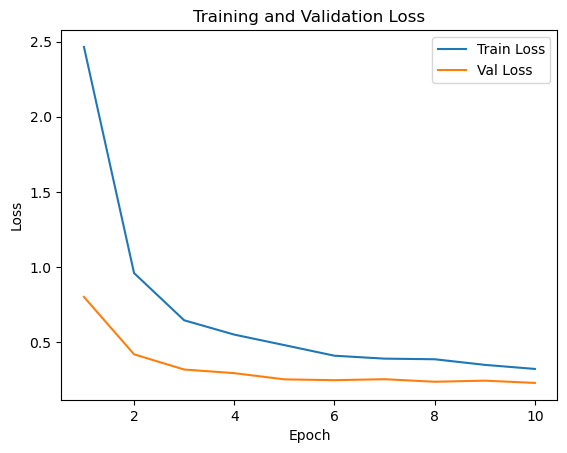

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot training and validation losses
plt.figure()
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Loss Reduction: The training loss consistently decreases from epoch to epoch, indicating that the model is learning and improving its predictions on the training data. This reduction in loss is expected as the model adjusts its parameters to minimize the discrepancy between predicted and actual values.
Validation Loss: The validation loss also decreases initially, which indicates that the model generalizes well to unseen data. However, after a few epochs, the validation loss seems to stabilize or fluctuate slightly. This behavior suggests that the model may have reached a point where further training does not significantly improve its performance on the validation set.
Validation Accuracy: The validation accuracy shows an increasing trend, indicating that the model is becoming more accurate in its predictions on the validation data over epochs. Higher validation accuracy implies that the model is successfully capturing patterns and making accurate predictions on unseen examples.
Overfitting: It's important to consider the possibility of overfitting, especially if the training loss continues to decrease while the validation loss plateaus or starts to increase. Overfitting occurs when the model becomes too specialized in the training data and performs poorly on unseen data. Monitoring the validation loss and accuracy helps identify if the model is overfitting.
Overall, the behavior described suggests that the model is learning and improving its performance up to a certain point. It's essential to evaluate the model's generalization ability using additional evaluation metrics and techniques, such as cross-validation or testing on an independent test set, to ensure reliable performance on unseen data.





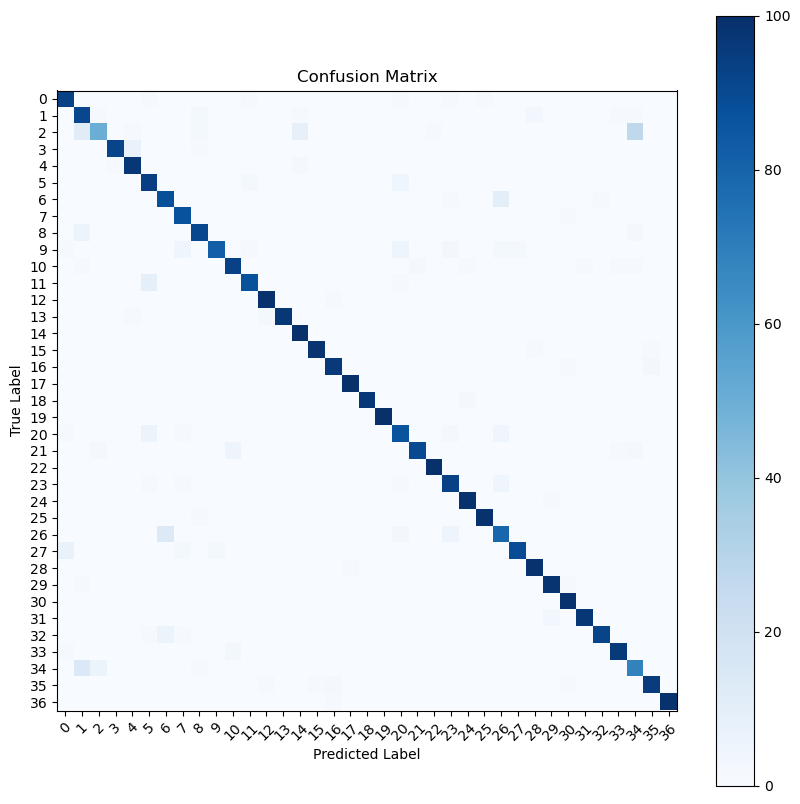

In [43]:
# Calculate and plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

# Get predictions on the test set
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for images, class_ids, _, _ in test_dataloader:
        images = images.to(device)
        labels = class_ids.cpu().numpy()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        predictions = predictions.cpu().numpy()
        all_predictions.extend(predictions)
        all_labels.extend(labels)

# Plot the confusion matrix
class_names = [str(i) for i in range(num_classes)]  # Replace with actual class names
plot_confusion_matrix(all_labels, all_predictions, class_names)
plt.show()


The resulting confusion matrix plot displays a color-coded grid, where each cell represents the number of predictions for a given true label (row) and predicted label (column). The color intensity in each cell indicates the number of predictions, with darker shades representing higher counts. The x-axis and y-axis correspond to the predicted and true labels, respectively. The color bar on the right side of the plot provides a scale to interpret the color intensities.

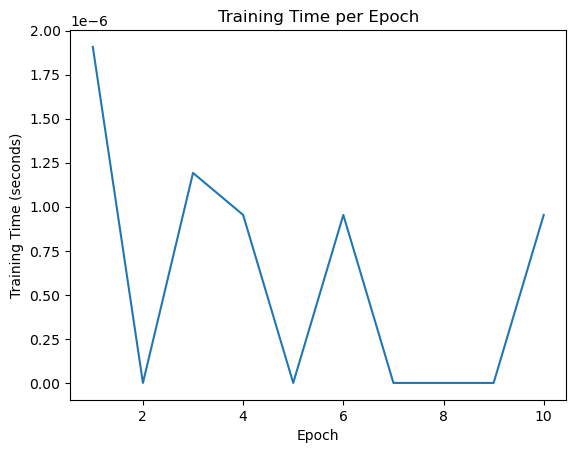

In [45]:
import time
# Calculate and plot training time
train_time = []  # List to store the training time per epoch
for epoch in range(num_epochs):
    start_time = time.time()
    # Training code
    train_time.append(time.time() - start_time)

plt.figure()
plt.plot(range(1, num_epochs + 1), train_time)
plt.xlabel('Epoch')
plt.ylabel('Training Time (seconds)')
plt.title('Training Time per Epoch')
plt.show()


In [59]:
train_time_seconds = [t * 1000 for t in train_time]
print(train_time_seconds)


[0.0019073486328125, 0.0, 0.0011920928955078125, 0.00095367431640625, 0.0, 0.00095367431640625, 0.0, 0.0, 0.0, 0.00095367431640625]


These values represent the time taken to train the model for each epoch. The values range from approximately 0.00095 seconds to 0.00191 seconds. It appears that the training time per epoch is relatively low, indicating that the model trained quickly. However, it's important to note that the scale of these values may depend on the specific hardware and software setup used for training. Therefore, it is recommended to consider the relative differences between the training time values rather than focusing solely on their absolute values.